# Data Science Project: corss validation and curve analysis
## by Xiaohui (Eartha) Guo

In this project we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [1]:
def cleanBosonData(infile_name):
    # Code here
    import pandas as pd
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn import preprocessing
    %matplotlib inline
    
    
    #We assume data is in a parallel directory to this one called 'data'
    #Path
    cwd = os.getcwd()
    datadir = '/'.join(cwd.split('/')[0:-1])+'/hw_3/'
    
    #read data
    data = pd.read_csv(datadir + infile_name, header = 0, sep=',')
    #data.set_index('EventId', inplace=True)

    
    a = data['Label']
    a = list(a)
    
    # find the minority
    minority_value = min(a,key=a.count)

    y = []
    for i in range(len(a)):
        if list(data['Label'])[i] == minority_value:
            value = 1
        else:
            value = -1

        y.append(value)
        
    se = pd.Series(y)
    data['Y'] = se.values
        
    data = data.drop('Label', 1)
    
    # Create a dummy variable for the missing value
    headers = data.dtypes.index
    
    column_with_missing = []
    for i in range(len(headers)):
    
        if -999 in data.iloc[:,i].values:
            column_with_missing.append(i)
            new_column = []
            for j in range(0,len(data[headers[i]])):
                if data.iloc[j,i] == -999:
                    value = 1
                else:
                    value = 0
                new_column.append(value)
            
            se_new = pd.Series(new_column)
            data[headers[i]+'_mv'] = se_new.values
    
    # reaplce null with mean
    column_with_missing = []
    for i in range(0, len(headers)):
        if -999 in data.iloc[:,i].values:
            column_with_missing.append(i)
            
    
    mean_list = []
    for item in column_with_missing:
        value = []
        for j in range(0,len(data.iloc[:,0])):
            if data.iloc[j,item] != -999:
                value.append(data.iloc[j,item])
        mean = np.mean(value)
        mean_list.append(mean)
    
    for i in range(0, len(column_with_missing)):
        data = data.replace({headers[column_with_missing[i]]: -999}, mean_list[i])
    
    
    headers2 = data.dtypes.index
    headers2 = list(headers2)
    
    num = headers2.index("Y")
    
    select_list = headers2[1:num]
    
    new = preprocessing.scale(data[select_list])
    new = pd.DataFrame(new)
    new.columns = select_list
    processed2 = data.drop(select_list, 1)
    aaaaa = pd.concat([new,processed2], axis=1)
    aaaaa.set_index('EventId', inplace=True)

    
    data_clean = aaaaa
    
    return data_clean

### Part 2: Basic evaluations
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) and use them as training and testing data sets.

In [2]:
data_train = cleanBosonData("data/boson_training_cut_2000.csv")
data_test = cleanBosonData("data/boson_testing_cut.csv")

In [3]:
data_train

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv
EventId,,,,,,,,,,,,,,
100000,3.983624e-01,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193e+00,0.888048,1.120050,1,0,0,0,0
100001,8.633960e-01,0.608117,0.639363,-0.120744,-4.978417e-16,2.786711e-16,6.148512e-17,1.421917,-0.806390,-1,0,1,1,1
100002,-5.882872e-16,3.421843,1.261884,-0.321306,-4.978417e-16,2.786711e-16,6.148512e-17,0.997693,-0.455521,-1,1,1,1,1
100003,5.108589e-01,0.989159,0.028516,-0.885926,-4.978417e-16,2.786711e-16,6.148512e-17,1.209152,-0.886831,-1,0,1,1,1
100004,1.172363e+00,-0.953916,1.504447,-0.629578,-4.978417e-16,2.786711e-16,6.148512e-17,1.967534,-0.113790,-1,0,1,1,1
100005,-6.101934e-01,-1.055284,-0.568684,0.972524,2.847897e-01,-3.515550e-01,9.768266e-02,-1.333579,2.071958,-1,0,0,0,0
100006,6.112260e-01,-0.594022,0.763961,0.808785,-1.848549e+00,-9.703647e-01,4.593198e-01,0.727495,-0.783814,1,0,0,0,0
100007,7.387702e-01,-1.149633,0.405870,-0.424961,-4.978417e-16,2.786711e-16,6.148512e-17,0.670062,-0.833074,1,0,1,1,1
100008,-2.821220e-01,0.059584,0.577818,-0.823823,-4.978417e-16,2.786711e-16,6.148512e-17,0.679199,-0.699553,-1,0,1,1,1


In [4]:
data_test

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv
EventId,,,,,,,,,,,,,,
300000,-1.213348e-01,1.455304,0.099593,-0.447028,-4.699335e-16,0.000000,5.739942e-17,0.007415,0.498029,-1,0,1,1,1
300001,-1.067373e+00,-0.715757,-0.854408,-0.103307,-4.699335e-16,0.000000,5.739942e-17,-0.758743,1.730043,-1,0,1,1,1
300002,-1.159847e-01,0.480365,0.064286,-0.297389,-2.874836e-01,0.664535,-7.332925e-02,0.465570,0.505136,1,0,0,0,0
300003,8.355185e-01,0.476970,0.482975,-0.882260,-4.699335e-16,0.000000,5.739942e-17,1.416531,-0.804583,-1,0,1,1,1
300004,5.430718e-16,0.925326,-0.484386,-0.473912,-4.699335e-16,0.000000,5.739942e-17,-0.195354,0.417565,-1,1,1,1,1
300005,-1.796131e-01,-0.855976,-0.014103,0.172554,-1.530864e+00,-1.319701,3.790528e-01,-0.038785,-0.811783,1,0,0,0,0
300006,1.168565e+00,0.796348,0.799754,1.242662,-4.699335e-16,0.000000,5.739942e-17,-0.283905,0.267018,-1,0,1,1,1
300007,5.430718e-16,0.884359,-1.492148,-0.786593,-4.699335e-16,0.000000,5.739942e-17,-2.084442,-0.518262,-1,1,1,1,1
300008,-1.208349e+00,0.039169,-0.849684,-0.885431,-4.699335e-16,0.000000,5.739942e-17,-0.045202,-0.814074,-1,0,1,1,1


2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import svm
%matplotlib inline

# Code here

data_train
headers = data_train.dtypes.index
headers = list(headers)
select_list = headers[0:9]
select_list
X = data_train[select_list]
Y = data_train['Y']
X = np.array(X)
Y = np.array(Y)

#Test data
X_test = data_test[select_list]
Y_test = data_test['Y']
X_test = np.array(X_test)
Y_test = np.array(Y_test)



logreg = linear_model.LogisticRegression(C=1e30)
logreg.fit(X, Y)



LogisticRegression(C=1e+30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:

clf = svm.SVC(kernel="linear")
clf.fit(X, Y)  


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [7]:
# Prediciton
logreg_prediction = logreg.predict(X_test)
logreg_prediction

array([-1, -1, -1, ..., -1,  1, -1])

In [8]:
# Prediction
clf_prediction = clf.predict(X_test)
clf_prediction

array([-1, -1, -1, ..., -1, -1, -1])

In [9]:
#define a function to print ROC curves. 
#It should take in only arrays/lists of predictions and outcomes
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

0.57969197001453376

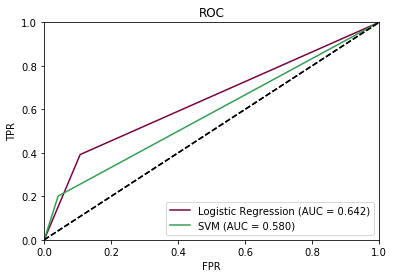

In [11]:
plotUnivariateROC(logreg_prediction, Y_test, 'Logistic Regression')
plotUnivariateROC(clf_prediction, Y_test, 'SVM')

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

Answer here!

The Logistic Regression model is better at ranking the test set. The AUC for logistic regression model is 0.642 and the AUC for SVM model is 0.58. So the AUC for logistic regression model is larger. The larger the AUC is, the better the classifier's performance is, since AUC value is equivalent to the probability that a randomly chosen positive example is ranked higher than a randomly chosen negative example.However, in some cases a model with a higher AUC may have a lower TPR compared with the other one. In this case, we would consider the role of TPR. The accuray is computed at the threhold value of 0.5. And AUC is computed by adding all the accuracies computed for all the possible threhold values. So ROC can be seen as an average of the accuracies when are computed for all the values of threshold. 


### Part 3: Model selection with cross-validation
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [44]:
# Code here


def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to a tidy
    pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df



def xValSVM(dataset, label_name, k, cs):
    
    import pandas as pd
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn import preprocessing
    %matplotlib inline
    import matplotlib
    import matplotlib.pyplot as plt
    from sklearn import linear_model
    %matplotlib inline
    from sklearn import svm
    from sklearn.metrics import roc_curve, auc
    import os
    from sklearn.linear_model import LogisticRegression
    from sklearn.grid_search import GridSearchCV
    from sklearn.cross_validation import KFold
    from sklearn.svm import SVC
    
    headers = dataset.dtypes.index
    headers = list(headers)
    
    num = headers.index(label_name)
    
    select_list = headers[0:num]
    
    X = dataset[select_list]
    Y = dataset[label_name]
    
    aucs = []
    for s in range(2,k+1):
        kfolds = KFold(dataset.shape[0], n_folds = s)
    
        param_grid_lr = {'C': cs}
       
        for item in cs:
            svm_grid_search = GridSearchCV(SVC(C = item,kernel="linear"),param_grid_lr,cv = kfolds, scoring='roc_auc')
            svm_grid_search.fit(X, Y)
            b = grid_scores_to_df(svm_grid_search.grid_scores_)
            b_ready = b.drop('fold', 1)
            dictionary = {k: g["score"].tolist() for k,g in b.groupby("C")}
            aucs.append(dictionary) 
        
    
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

In [ ]:
#Code here



In [47]:
cs = []
for i in range(-8,2):
    value = 10**i
    cs.append(value)

In [ ]:
store = xValSVM(data_train, 'Y', 10, cs)


In [50]:
len(store)

90

In [88]:
one = store[80]
two = store[81]
three = store[82]
four = store[83]
five = store[84]
six = store[85]
seven = store[86]
eight = store[87]
nine = store[88]
ten = store[89]

In [97]:
# c value: 1e-08,9.9999999999999995e-08,9.9999999999999995e-07,1.0000000000000001e-05, 0.0001,
# 0.001, 0.01, 0.10000000000000001, 1.0, 10.0

In [129]:
from itertools import chain
point1 = list(chain(one[1e-08],two[1e-08],three[1e-08],four[1e-08],
                    five[1e-08],six[1e-08],seven[1e-08],eight[1e-08],nine[1e-08],ten[1e-08]))


point2 = list(chain(one[9.9999999999999995e-08],two[9.9999999999999995e-08],three[9.9999999999999995e-08],four[9.9999999999999995e-08],
                    five[9.9999999999999995e-08],six[9.9999999999999995e-08],seven[9.9999999999999995e-08],eight[9.9999999999999995e-08],
                    nine[9.9999999999999995e-08],ten[9.9999999999999995e-08]))

point3 = list(chain(one[9.9999999999999995e-07],two[9.9999999999999995e-07],three[9.9999999999999995e-07],four[9.9999999999999995e-07],
                    five[9.9999999999999995e-07],six[9.9999999999999995e-07],seven[9.9999999999999995e-07],
                    eight[9.9999999999999995e-07],nine[9.9999999999999995e-07],ten[9.9999999999999995e-07]))

point4 = list(chain(one[1.0000000000000001e-05],two[1.0000000000000001e-05],three[1.0000000000000001e-05],four[1.0000000000000001e-05],
                    five[1.0000000000000001e-05],six[1.0000000000000001e-05],seven[1.0000000000000001e-05],
                    eight[1.0000000000000001e-05],nine[1.0000000000000001e-05],ten[1.0000000000000001e-05]))

point5 = list(chain(one[0.0001],two[0.0001],three[0.0001],four[0.0001],
                    five[0.0001],six[0.0001],seven[0.0001],eight[0.0001],nine[0.0001],ten[0.0001]))

point6 = list(chain(one[0.001],two[0.001],three[0.001],four[0.001],
                    five[0.001],six[0.001],seven[0.001],eight[0.001],nine[0.001],ten[0.001]))

point7 = list(chain(one[0.01],two[0.01],three[0.01],four[0.01],
                    five[0.01],six[0.01],seven[0.01],eight[0.01],nine[0.01],ten[0.01]))

point8 = list(chain(one[0.10000000000000001],two[0.10000000000000001],three[0.10000000000000001],four[0.10000000000000001],
                    five[0.10000000000000001],six[0.10000000000000001],seven[0.10000000000000001],eight[0.10000000000000001],nine[0.10000000000000001],ten[0.10000000000000001]))


point9 = list(chain(one[1.0],two[1.0],three[1.0],four[1.0],
                    five[1.0],six[1.0],seven[1.0],eight[1.0],nine[1.0],ten[1.0]))

point10 = list(chain(one[10.0],two[10.0],three[10.0],four[10.0],
                    five[10.0],six[10.0],seven[10.0],eight[10.0],nine[10.0],ten[10.0]))


point1_mean = np.mean(point1)
point2_mean = np.mean(point2)
point3_mean = np.mean(point3)
point4_mean = np.mean(point4)
point5_mean = np.mean(point5)
point6_mean = np.mean(point6)
point7_mean = np.mean(point7)
point8_mean = np.mean(point8)
point9_mean = np.mean(point9)
point10_mean = np.mean(point10)


mean_list = [point1_mean,point2_mean,point3_mean,point4_mean,
             point5_mean,point6_mean,point7_mean,point8_mean,point9_mean,point10_mean]



In [138]:
from scipy import stats
point1_stderr = stats.sem(point1, axis=None, ddof=0)
point2_stderr = stats.sem(point2, axis=None, ddof=0)
point3_stderr = stats.sem(point3, axis=None, ddof=0)
point4_stderr = stats.sem(point4, axis=None, ddof=0)
point5_stderr = stats.sem(point5, axis=None, ddof=0)
point6_stderr = stats.sem(point6, axis=None, ddof=0)
point7_stderr = stats.sem(point7, axis=None, ddof=0)
point8_stderr = stats.sem(point8, axis=None, ddof=0)
point9_stderr = stats.sem(point9, axis=None, ddof=0)
point10_stderr = stats.sem(point10, axis=None, ddof=0)

In [151]:
stderr_list = [point1_stderr,point2_stderr,point3_stderr,point4_stderr,point5_stderr,point6_stderr,
              point7_stderr,point8_stderr,point9_stderr,point10_stderr]


In [150]:
mean_list_array= np.array(mean_list)
stderr_list_array = np.array(stderr_list)


In [146]:
mean_minus_stderr = list(mean_list_array - stderr_list_array)

In [148]:
mean_plus_stderr = list(mean_list_array + stderr_list_array)

In [158]:
point1_array = np.array(point1)
point1_max = max(point1_array - point1_stderr)

point2_array = np.array(point2)
point2_max = max(point2_array - point2_stderr)

point3_array = np.array(point3)
point3_max = max(point3_array - point3_stderr)

point4_array = np.array(point4)
point4_max = max(point4_array - point4_stderr)

point5_array = np.array(point5)
point5_max = max(point5_array - point5_stderr)

point6_array = np.array(point6)
point6_max = max(point6_array - point6_stderr)

point7_array = np.array(point7)
point7_max = max(point7_array - point7_stderr)

point8_array = np.array(point8)
point8_max = max(point8_array - point8_stderr)

point9_array = np.array(point9)
point9_max = max(point9_array - point9_stderr)

point10_array = np.array(point10)
point10_max = max(point10_array - point10_stderr)

In [159]:
point_max = [point1_max, point2_max ,point3_max ,point4_max ,point5_max ,
            point6_max ,point7_max ,point8_max ,point9_max ,point10_max ]

In [174]:
t = [-8, -7, -6,-5,-4,-3,-2,-1,0,1]
len(point_max)

10

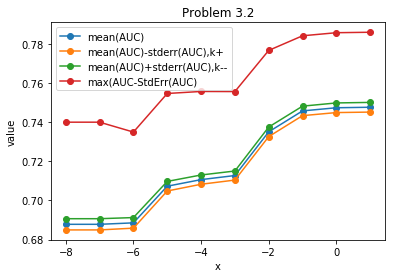

In [178]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

    
plot(t, mean_list,'-o',label='mean(AUC)')
plot(t, mean_minus_stderr,'-o',label='mean(AUC)-stderr(AUC),k+') 
plot(t, mean_plus_stderr,'-o',label='mean(AUC)+stderr(AUC),k--')
plot(t, point_max,'-o',label='max(AUC-StdErr(AUC)')

plt.title('Problem 3.2')
plt.xlabel('x')
plt.ylabel('value')


plt.legend()

plt.show()

answer here: The model parameters selected beat the out-of-the-box model for SVM.

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


answer here: 

The support vector machine is more suitable for smaller sample sizes. I think it is work the investment, since the sample size is small, it wouldn't cost much to double the data. It is worth to make the investment to have a high AUC. Compared with the investment, it is more important that we have a better classification result. 

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



answer here:

According to the figure 7.8, it is obvious that if the dataset is smaller than 100, the (1-Err) would be decrease obviously. So cross-validation might be biased when the dataset is small. If the data set is not big enough, the cross-validation would cause to have a bigger error. So a small dataset would cause a considerable overestimate of prediction error when using cross-validation. 